In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

Could not save font_manager cache Lock error: Matplotlib failed to acquire the following lock file:
    C:\Users\deepa\.matplotlib\fontlist-v390.json.matplotlib-lock
This maybe due to another process holding this lock file.  If you are sure no
other Matplotlib process is running, remove this file and try again.


In [3]:
# ------------------ CONFIG ------------------
# Set your CSV path here. If this path doesn't exist, we try a local TSLA.csv.
CSV_PATH = "TSLA.csv"  # change to your file if needed, e.g. r"C:\path\to\TSLA.csv"
TARGET_COL = "Close"   # model predicts next-day Close
TEST_SIZE_FRACTION = 0.2   # last 20% rows as test
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)



In [4]:
# ------------------ LOAD DATA ------------------
if not os.path.exists(CSV_PATH):
    # Fallback to repo-style relative path if needed
    fallback = os.path.join(".", "TSLA.csv")
    if os.path.exists(fallback):
        CSV_PATH = fallback
    else:
        raise FileNotFoundError(
            f"Could not find CSV at '{CSV_PATH}'. Put your CSV next to this script or update CSV_PATH."
        )

df = pd.read_csv(CSV_PATH)


In [5]:
# Normalize common column names
date_col = None
for c in df.columns:
    if str(c).lower() in ("date", "timestamp"):
        date_col = c
        break
if date_col is None:
    raise ValueError("No 'Date' (or 'Timestamp') column found in the CSV.")

df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(by=date_col).reset_index(drop=True)



C:\Users\deepa\AppData\Local\Temp\ipykernel_22176\1645950558.py:10: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_col] = pd.to_datetime(df[date_col])


In [6]:
# Try to find a usable close column
close_candidates = [col for col in df.columns if str(col).lower() in ("close", "adj close", "adj_close", "adjclose")]
if TARGET_COL not in df.columns:
    if close_candidates:
        TARGET_COL = close_candidates[0]
    else:
        raise ValueError("Could not find a 'Close' column (or 'Adj Close') to use as target.")

# ------------------ FEATURE ENGINEERING ------------------
data = df.copy()



In [7]:
# ------------------ FEATURE ENGINEERING ------------------
data = df.copy()



In [8]:
# Basic returns
data["return_1d"] = data[TARGET_COL].pct_change()
data["return_5d"] = data[TARGET_COL].pct_change(5)
data["return_10d"] = data[TARGET_COL].pct_change(10)



In [9]:
# Rolling statistics
for w in [5, 10, 20]:
    data[f"sma_{w}"] = data[TARGET_COL].rolling(w).mean()
    data[f"std_{w}"] = data[TARGET_COL].rolling(w).std()



In [10]:
# RSI(14)
# RSI helper
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(period).mean()
    loss = -delta.clip(upper=0).rolling(period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data["rsi_14"] = compute_rsi(data[TARGET_COL], 14)



In [11]:
# MACD (12, 26, 9)
ema12 = data[TARGET_COL].ewm(span=12, adjust=False).mean()
ema26 = data[TARGET_COL].ewm(span=26, adjust=False).mean()
data["macd"] = ema12 - ema26
data["macd_signal"] = data["macd"].ewm(span=9, adjust=False).mean()
data["macd_hist"] = data["macd"] - data["macd_signal"]



In [12]:
# Lags of Close (predict next-day close from lagged info)
for lag in [1, 2, 3, 5, 10]:
    data[f"close_lag_{lag}"] = data[TARGET_COL].shift(lag)



In [13]:
# Target: next-day Close (shift -1)
data["target_next_close"] = data[TARGET_COL].shift(-1)



In [14]:
# Drop rows with NaNs introduced by indicators/shift
data_model = data.dropna().reset_index(drop=True)



In [15]:
# Features/Target selection
feature_cols = [
    "return_1d", "return_5d", "return_10d",
    "sma_5", "sma_10", "sma_20",
    "std_5", "std_10", "std_20",
    "rsi_14",
    "macd", "macd_signal", "macd_hist",
    "close_lag_1", "close_lag_2", "close_lag_3", "close_lag_5", "close_lag_10",
]
X = data_model[feature_cols].values
y = data_model["target_next_close"].values
dates = data_model[date_col].values



In [16]:
# ------------------ TRAIN/TEST SPLIT (time-order) ------------------
n = len(data_model)
test_size = int(math.ceil(TEST_SIZE_FRACTION * n))
train_end = n - test_size
X_train, X_test = X[:train_end], X[train_end:]
y_train, y_test = y[:train_end], y[train_end:]
dates_train, dates_test = dates[:train_end], dates[train_end:]



In [17]:
# ------------------ SCALE FEATURES (fit on train only) ------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------ MODEL ------------------
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train_scaled, y_train)



,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [22]:
# ------------------ EVALUATION ------------------
y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print("Test Metrics:")
print(f"  MAE : {mae:,.4f}")
print(f"  RMSE: {rmse:,.4f}")
print(f"  MAPE: {mape:,.2f}%")
print(f"  R^2 : {r2:,.4f}")



Test Metrics:
  MAE : 478.2837
  RMSE: 572.8426
  MAPE: 75.18%
  R^2 : -2.2991


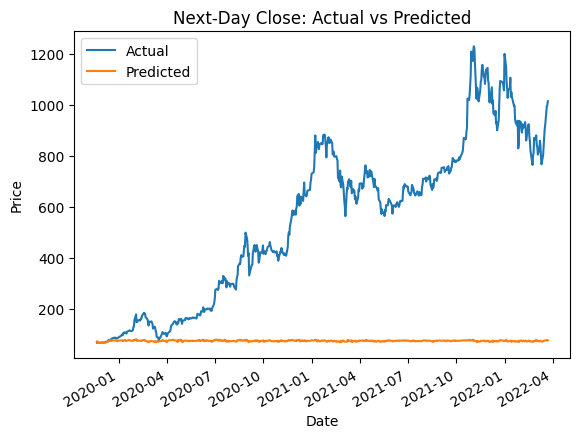

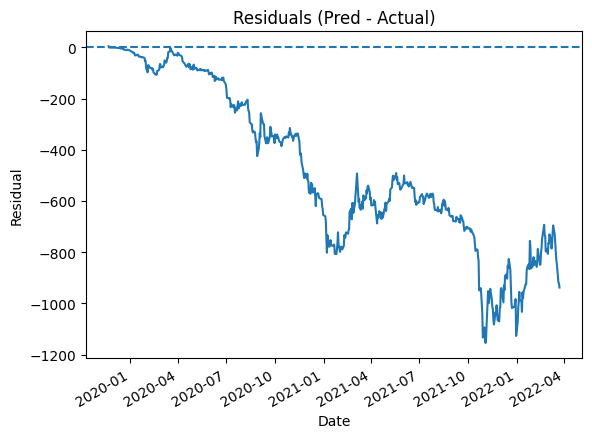

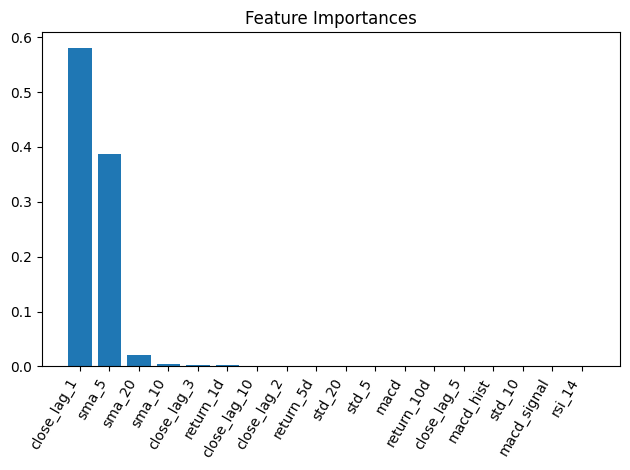

In [24]:
# ------------------ PLOTS ------------------
# 1) Predictions vs Actuals over time
fig1 = plt.figure()
plt.plot(dates_test, y_test, label="Actual")
plt.plot(dates_test, y_pred, label="Predicted")
plt.title("Next-Day Close: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
fig1.autofmt_xdate()
fig1.savefig(os.path.join(OUTPUT_DIR, "pred_vs_actual.png"), bbox_inches="tight")
plt.show()

# 2) Residuals (Predicted - Actual)
residuals = y_pred - y_test
fig2 = plt.figure()
plt.plot(dates_test, residuals)
plt.axhline(0, linestyle="--")
plt.title("Residuals (Pred - Actual)")
plt.xlabel("Date")
plt.ylabel("Residual")
fig2.autofmt_xdate()
fig2.savefig(os.path.join(OUTPUT_DIR, "residuals.png"), bbox_inches="tight")
plt.show()

# 3) Feature Importances
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    idxs = np.argsort(importances)[::-1]
    fig3 = plt.figure()
    plt.bar(range(len(feature_cols)), importances[idxs])
    plt.xticks(range(len(feature_cols)), [feature_cols[i] for i in idxs], rotation=60, ha="right")
    plt.title("Feature Importances")
    plt.tight_layout()
    fig3.savefig(os.path.join(OUTPUT_DIR, "feature_importances.png"), bbox_inches="tight")
    plt.show()



In [25]:
# ------------------ NEXT-DAY FORECAST ------------------
# Use the latest available row (already shifted, so get the last row BEFORE we dropped NA)
latest_row = data.tail(1).copy()  # last available day in the original sorted df
# To predict next day's close, we need the latest features (which require lags & indicators).
# We'll re-build the feature row from the last non-NA row in data_model (already aligned).
X_last = data_model[feature_cols].iloc[[-1]].values
X_last_scaled = scaler.transform(X_last)
next_day_pred = model.predict(X_last_scaled)[0]
print(f"\nPredicted NEXT-DAY Close: {next_day_pred:,.4f}")




Predicted NEXT-DAY Close: 75.7123


In [27]:
# Save metrics & prediction
with open(os.path.join(OUTPUT_DIR, "report.txt"), "w") as f:
    f.write("Stock Price Prediction Report\n")
    f.write(f"CSV: {CSV_PATH}\n")
    f.write(f"Rows used: {n}\n")
    f.write("\nTest Metrics:\n")
    f.write(f"MAE : {mae:,.4f}\n")
    f.write(f"RMSE: {rmse:,.4f}\n")
    f.write(f"MAPE: {mape:,.2f}%\n")
    f.write(f"R^2 : {r2:,.4f}\n")
    f.write(f"\nPredicted NEXT-DAY Close: {next_day_pred:,.4f}\n")

print(f"\nSaved files in ./{OUTPUT_DIR}/")
print(" - pred_vs_actual.png")
print(" - residuals.png")
if hasattr(model, 'feature_importances_'):
    print(" - feature_importances.png")
print(" - report.txt")



Saved files in ./outputs/
 - pred_vs_actual.png
 - residuals.png
 - feature_importances.png
 - report.txt
